In [1]:
# Added SE blocks (+ Slightly stronger SpecAugment)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as L, models as M, callbacks as C, optimizers as O
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

2025-09-10 13:48:52.124261: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-10 13:48:52.151156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-10 13:48:52.779350: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# =========================
#           PATHS
# =========================
DRONE_ROOT   = r"/home/destrox-907/Husnian_FYP/Dataset/MFCC Drone Dataset/MFCC Drone Dataset"
NODRONE_ROOT = r"/home/destrox-907/Husnian_FYP/Dataset/MFCC Noise Dataset/MFCC Noise Dataset"

# =========================
#      CONFIG / HYPERS
# =========================
INPUT_SHAPE     = (13, 40, 1)
BATCH_SIZE      = 128
EPOCHS          = 40
LEARNING_RATE   = 1e-3
MIXUP_ALPHA     = 0.3
USE_SPECAUG     = True
VAL_SIZE        = 0.20
SEED            = 42

# =========================
#  RECURSIVE DATA LOADING
# =========================
def collect_npy_paths(root_dir):
    paths = []
    for r, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(".npy"):
                paths.append(os.path.join(r, f))
    return paths

def load_paths_and_labels(drone_root, nodrone_root):
    drone_paths   = collect_npy_paths(drone_root)
    nodrone_paths = collect_npy_paths(nodrone_root)
    paths  = np.array(drone_paths + nodrone_paths)
    labels = np.array([1]*len(drone_paths) + [0]*len(nodrone_paths), dtype=np.int32)
    return paths, labels

paths, labels = load_paths_and_labels(DRONE_ROOT, NODRONE_ROOT)
print(f"Total .npy files: {len(paths)} | drone={labels.sum()} | no_drone={len(labels)-labels.sum()}")

X_train, X_val, y_train, y_val = train_test_split(
    paths, labels, test_size=VAL_SIZE, random_state=SEED, stratify=labels
)

# =========================
#     DATA PIPELINE
# =========================
def npy_loader(path):
    try:
        arr = np.load(path.decode("utf-8")).astype("float32")
        arr = np.reshape(arr, (13, 40, 1))
        return arr
    except Exception as e:
        print(f"[WARN] Failed to load {path.decode('utf-8')}: {e}")
        return np.zeros((13, 40, 1), dtype="float32")

def tf_load(path, label, training=True):
    x = tf.numpy_function(npy_loader, [path], Tout=tf.float32)
    x = tf.ensure_shape(x, INPUT_SHAPE)

    if training and USE_SPECAUG:
        # >>> CHANGED: slightly stronger SpecAugment
        def _specaug(a):
            a = a.copy()
            f_dim, t_dim, _ = a.shape  # 13,40,1
            # freq masks (up to 4 MFCC bins), 3 masks
            for _ in range(3):
                f = np.random.randint(0, 5)
                if f > 0:
                    f0 = np.random.randint(0, f_dim - f + 1)
                    a[f0:f0+f, :, :] = 0.0
            # time masks (up to 10 frames), 3 masks
            for _ in range(3):
                t = np.random.randint(0, 11)
                if t > 0:
                    t0 = np.random.randint(0, t_dim - t + 1)
                    a[:, t0:t0+t, :] = 0.0
            return a
        x = tf.numpy_function(_specaug, [x], Tout=tf.float32)
        x = tf.ensure_shape(x, INPUT_SHAPE)

    y = tf.one_hot(label, 2)
    return x, y

def make_dataset(paths, labels, batch=BATCH_SIZE, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(8192, reshuffle_each_iteration=True)
    ds = ds.map(lambda p, l: tf_load(p, l, training=training),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch)

    if training and MIXUP_ALPHA > 0.0:
        def mixup_batch(x, y):
            lam = tf.random.uniform([], 0.5, 1.0)
            idx = tf.random.shuffle(tf.range(tf.shape(x)[0]))
            x2 = tf.gather(x, idx); y2 = tf.gather(y, idx)
            return lam*x + (1-lam)*x2, lam*y + (1-lam)*y2
        ds = ds.map(mixup_batch, num_parallel_calls=tf.data.AUTOTUNE)

    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(X_train, y_train, training=True)
val_ds   = make_dataset(X_val,   y_val,   training=False)


Total .npy files: 390897 | drone=268268 | no_drone=122629


I0000 00:00:1757494137.328087   45328 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 897 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1757494137.329288   45328 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21370 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:05:00.0, compute capability: 8.9


In [3]:
# =========================
#   RESNET-LIKE BACKBONE (+SE)
# =========================
# >>> CHANGED: add Squeeze-and-Excitation
def squeeze_excite(x, r=8):
    c = x.shape[-1]
    s = L.GlobalAveragePooling2D()(x)
    s = L.Dense(max(c//r, 8), activation="relu")(s)
    s = L.Dense(c, activation="sigmoid")(s)
    s = L.Reshape((1,1,c))(s)
    return L.Multiply()([x, s])

def res_block(x, filters, stride=1, use_se=False):
    shortcut = x
    x = L.Conv2D(filters, (3,3), strides=stride, padding="same", use_bias=False)(x)
    x = L.BatchNormalization()(x); x = L.ReLU()(x)
    x = L.Conv2D(filters, (3,3), padding="same", use_bias=False)(x)
    x = L.BatchNormalization()(x)
    if use_se:
        x = squeeze_excite(x)  # <<< SE
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = L.Conv2D(filters, (1,1), strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = L.BatchNormalization()(shortcut)
    x = L.Add()([x, shortcut]); x = L.ReLU()(x)
    return x

def build_model(input_shape=(13,40,1), num_classes=2):
    inp = L.Input(shape=input_shape)
    x = L.Conv2D(32, (3,3), padding="same", use_bias=False)(inp)
    x = L.BatchNormalization()(x); x = L.ReLU()(x)

    x = res_block(x, 32, use_se=True)
    x = res_block(x, 32, use_se=True)
    x = L.MaxPool2D(pool_size=(1,2))(x)

    x = res_block(x, 64, stride=2, use_se=True)
    x = res_block(x, 64, use_se=True)

    x = L.GlobalAveragePooling2D()(x)
    x = L.Dense(128, activation="relu")(x)
    x = L.Dropout(0.3)(x)
    out = L.Dense(num_classes, activation="softmax")(x)
    return M.Model(inp, out)

model = build_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 13, 40,    │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 40,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 13, 40,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 13, 40,    │      9,216 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 13, 40,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 40,    │      9,216 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │        264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        288 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 13, 40,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 13, 40,    │          0 │ multiply[0][0],   │
│                     │ 32)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 13, 40,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 13, 40,    │      9,216 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_3[0][0]  

 Total params: 182,018 (711.01 KB)

 Trainable params: 181,058 (707.26 KB)

 Non-trainable params: 960 (3.75 KB)

In [4]:
# =========================
#      TRAIN & EVAL
# =========================
opt = O.Adam(learning_rate=LEARNING_RATE)   # unchanged optimizer
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

cbs = [
    C.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1),
    C.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    C.ModelCheckpoint("drone_resnet_best.keras", monitor="val_accuracy", save_best_only=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cbs)

probs = model.predict(val_ds)[:, 1]
y_true = np.concatenate([y.numpy() for _, y in val_ds])[:, 1]
auroc = roc_auc_score(y_true, probs)
prec, rec, thr = precision_recall_curve(y_true, probs)
auprc = auc(rec, prec)
cands = np.linspace(0.05, 0.95, 19)
f1s = [f1_score(y_true, (probs >= t).astype(int)) for t in cands]
best_thr, best_f1 = cands[int(np.argmax(f1s))], max(f1s)


Epoch 1/40


2025-09-10 13:49:10.330508: I external/local_xla/xla/service/service.cc:163] XLA service 0x7c703c029020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-10 13:49:10.330520: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-10 13:49:10.330522: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-10 13:49:10.982480: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-10 13:49:11.418423: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-09-10 13:49:11.565165: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints

  16/2444 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6479 - loss: 0.6119 

I0000 00:00:1757494154.947559   45498 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2444/2444 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8383 - loss: 0.4208

2025-09-10 13:51:05.557372: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-10 13:51:05.830119: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_498', 4 bytes spill stores, 4 bytes spill loads

2025-09-10 13:51:05.939685: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_498', 384 bytes spill stores, 384 bytes spill loads



2444/2444 ━━━━━━━━━━━━━━━━━━━━ 119s 46ms/step - accuracy: 0.8585 - loss: 0.3952 - val_accuracy: 0.9379 - val_loss: 0.1689 - learning_rate: 0.0010
Epoch 2/40
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 108s 44ms/step - accuracy: 0.8821 - loss: 0.3643 - val_accuracy: 0.9604 - val_loss: 0.1316 - learning_rate: 0.0010
Epoch 3/40
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.8912 - loss: 0.3528 - val_accuracy: 0.9702 - val_loss: 0.1432 - learning_rate: 0.0010
Epoch 4/40
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 113s 46ms/step - accuracy: 0.8936 - loss: 0.3478 - val_accuracy: 0.9567 - val_loss: 0.1408 - learning_rate: 0.0010
Epoch 5/40
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 113s 46ms/step - accuracy: 0.8970 - loss: 0.3413 - val_accuracy: 0.9737 - val_loss: 0.0984 - learning_rate: 0.0010
Epoch 6/40
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 113s 46ms/step - accuracy: 0.8980 - loss: 0.3398 - val_accuracy: 0.9678 - val_loss: 0.1319 - learning_rate: 0.0010
Epoch 7/40
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 114s 47ms/step - accuracy: 

2025-09-10 14:45:46.829071: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# --- SAVE THE FINAL MODEL (whatever weights are in memory now) ---
model.save("drone_resnet_SE_Aug.keras")


=== Validation Metrics ===
AUROC  : 0.9988
AUPRC  : 0.9995
Best F1: 0.9910 @ threshold=0.30
Confusion Matrix (rows=true, cols=pred):
[[24126   400]
 [  565 53089]]


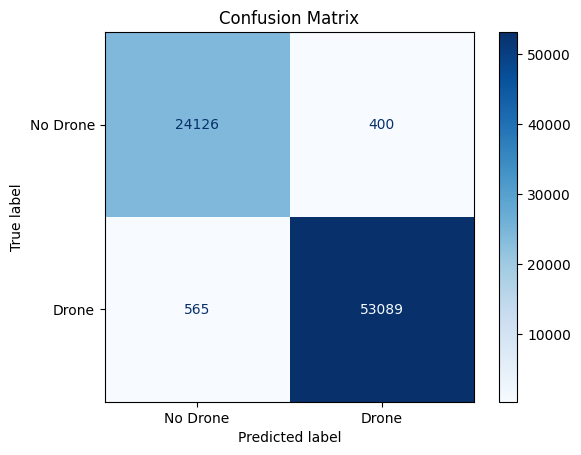


Classification Report:
              precision    recall  f1-score   support

    No Drone       0.98      0.98      0.98     24526
       Drone       0.99      0.99      0.99     53654

    accuracy                           0.99     78180
   macro avg       0.98      0.99      0.99     78180
weighted avg       0.99      0.99      0.99     78180



In [6]:
print(f"\n=== Validation Metrics ===")
print(f"AUROC  : {auroc:.4f}")
print(f"AUPRC  : {auprc:.4f}")
print(f"Best F1: {best_f1:.4f} @ threshold={best_thr:.2f}")

y_pred = (probs >= best_thr).astype(int)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Drone", "Drone"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["No Drone", "Drone"]))
